<a href="https://colab.research.google.com/github/park-geun-hyeong/first_deeplearning_from_keras/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library import 


In [ ]:
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from PIL import Image
import os
import shutil
from tqdm import tqdm

import keras.backend as k
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Dense, Flatten,Conv2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam



## Flower image datasets from OxFord
- 1360개의 Image(17개의 카테고리, 각각 80개씩)

In [ ]:
path = "/content/drive/MyDrive/keras_practice/CNN/Transfer_Learning"

In [ ]:
os.chdir('/content')
os.getcwd()

'/content'

- ImageDataGenerator를 사용하여 image를 나누기 위해 폴더별로 나누어 파일 이동

In [ ]:
img_list =sorted(os.listdir(path+'/oxford_flowers_17/17flowers/jpg'))  

In [ ]:
for i in range(17):
    os.mkdir(path+'/oxford_flowers_17/flower_'+str(i+1))
    

In [ ]:
for i in tqdm(range(17)):
    destination_path = path+'/oxford_flowers_17/flower_'+str(i+1)

    for j in range(80):
        file_name = path+'/oxford_flowers_17/17flowers/jpg/'+str(img_list[80*i+j])
        shutil.copy(file_name,destination_path)




100%|██████████| 17/17 [12:56<00:00, 45.69s/it]


In [ ]:
for i in range(17):
    file_list = os.listdir(path+'/oxford_flowers_17/flower_'+str(i+1))
    print("flower_"+str(i+1)+' file_num : {}'.format(len(file_list)))

flower_1 file_num : 80
flower_2 file_num : 80
flower_3 file_num : 80
flower_4 file_num : 80
flower_5 file_num : 80
flower_6 file_num : 80
flower_7 file_num : 80
flower_8 file_num : 80
flower_9 file_num : 80
flower_10 file_num : 80
flower_11 file_num : 80
flower_12 file_num : 80
flower_13 file_num : 80
flower_14 file_num : 80
flower_15 file_num : 80
flower_16 file_num : 80
flower_17 file_num : 80


- ImageDataGenerator의 flow_from_directory 함수를 사용하여 폴더별로 label을 나누어서 train,validation datasets로 분리

In [ ]:
CLASS_NUM = 17  ##
BATCH_SIZE =16
EPOCHS=14
INPUT_SHAPE=(224,224,3)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    path+'/oxford_flowers_17',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    path+'/oxford_flowers_17',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
) 

Found 1224 images belonging to 17 classes.
Found 136 images belonging to 17 classes.


## resnet model import

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

#include_top = False로 지정시 클래스 분류할 수 있는 마지막 레이어를 포함하지 않고 모델을 불러오는 것이다.
base_model_1 = ResNet50V2(include_top = False, weights='imagenet', input_shape=INPUT_SHAPE) 
base_model_2 = ResNet50V2(include_top = False, weights='imagenet', input_shape=INPUT_SHAPE)
base_model_3 = ResNet50V2(include_top = False, weights='imagenet', input_shape=INPUT_SHAPE)

## resnet모델을 통해 비교해 보고자 하는 것 
- ResNet50V2 model 전체 동결 ,Dense 레이어 추가
- ResNet50V2 model 첫 번째 블록 미세조정, Dense 레이어 추가
- ResNet50V2 model 마지막 블록 미세 조정, Dense 레이어 추가

In [ ]:
def create_model(base_model):
    resnet = base_model.output ##resnet model을 베이스로 하여 베이스 모델의 출력 layer을 가져온다.
    dropout = Dropout(0.3)(resnet)
    y = Flatten()(dropout)
    outputs =  Dense(CLASS_NUM, activation='softmax',kernel_initializer='he_normal',name='classification_layer')(y)

    model = Model(base_model.input,outputs) #전체 model은 resnet의 입력레이어부터 우리가 생성한 Dense 레이어 까지.
    return model 

model_1 = create_model(base_model_1)

model_1.trainable=True

set_trainable=False

for layer in model_1.layers: ##모델의 레이어를 돌면서 classification_layer라는 이름의 레이러를 만나면 그 레이어부터는 학습하도록 만들어주기.
    if layer.name == 'classificsation_layer':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable = False

model_1.summary()


In [62]:
model_1.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001), metrics=['acc'])

In [63]:
history_1 = model_1.fit_generator(generator=train_generator, validation_data=val_generator, epochs=EPOCHS, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/14
77/77 [==============================] - 118s 1s/step - loss: 5.6128 - acc: 0.0538 - val_loss: 5.0010 - val_acc: 0.0441
Epoch 2/14
77/77 [==============================] - 114s 1s/step - loss: 5.6969 - acc: 0.0681 - val_loss: 5.0010 - val_acc: 0.0441
Epoch 3/14
77/77 [==============================] - 115s 1s/step - loss: 5.7038 - acc: 0.0443 - val_loss: 5.0010 - val_acc: 0.0441
Epoch 4/14
77/77 [==============================] - 114s 1s/step - loss: 5.7479 - acc: 0.0557 - val_loss: 5.0010 - val_acc: 0.0441
Epoch 5/14
77/77 [==============================] - 114s 1s/step - loss: 5.7160 - acc: 0.0555 - val_loss: 5.0010 - val_acc: 0.0441
Epoch 6/14
77/77 [==============================] - 114s 1s/step - loss: 5.7423 - acc: 0.0573 - val_loss: 5.0010 - val_acc: 0.0441
Epoch 7/14
77/77 [==============================] - 114s 1s/step - loss: 5.6939 - acc: 0.0570 - val_loss: 5.0010 - val_acc: 0.0441
Epoch 8/14
77/77 [==============================] - 114s 1s/step - loss: 5.6800 - a

In [67]:
model_2 =create_model(base_model_2)
model_3 =create_model(base_model_3)

for layer in model_2.layers[0:16]:
    layer.trainable=True
for layer in model_2.layers[16:]:
    layer.trainable=False  #16번째 layer까지만 학습에들어간다(data의 input에 가까운부분)

for layer in model_3.layers[0:176]:
    layer.trainable=False
for layer in model_3.layers[176:]: #후반부 176번째 layer부터 학습에 들어간다 (출력에 가까운 부분 )
    layer.trainable=True


In [70]:
model_2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])
model_3.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])


In [71]:
history_2 = model_2.fit_generator(generator=train_generator, validation_data=val_generator, epochs=EPOCHS, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/14
77/77 [==============================] - 388s 5s/step - loss: 4.4980 - acc: 0.0521 - val_loss: 3.1260 - val_acc: 0.0882
Epoch 2/14
77/77 [==============================] - 383s 5s/step - loss: 3.2796 - acc: 0.0834 - val_loss: 2.8936 - val_acc: 0.0882
Epoch 3/14
77/77 [==============================] - 383s 5s/step - loss: 3.0315 - acc: 0.1289 - val_loss: 2.7664 - val_acc: 0.0735
Epoch 4/14
77/77 [==============================] - 383s 5s/step - loss: 2.9399 - acc: 0.1077 - val_loss: 2.6121 - val_acc: 0.1765
Epoch 5/14
77/77 [==============================] - 383s 5s/step - loss: 2.9459 - acc: 0.1027 - val_loss: 2.6427 - val_acc: 0.2059
Epoch 6/14
77/77 [==============================] - 384s 5s/step - loss: 2.7034 - acc: 0.1683 - val_loss: 2.6741 - val_acc: 0.2132
Epoch 7/14
77/77 [==============================] - 383s 5s/step - loss: 2.7113 - acc: 0.1503 - val_loss: 2.3760 - val_acc: 0.2426
Epoch 8/14
77/77 [==============================] - 383s 5s/step - loss: 2.6467 - a

In [72]:
history_3 = model_3.fit_generator(generator=train_generator, validation_data=val_generator, epochs=EPOCHS, verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/14
77/77 [==============================] - 148s 2s/step - loss: 2.5059 - acc: 0.5157 - val_loss: 5.6526 - val_acc: 0.7059
Epoch 2/14
77/77 [==============================] - 145s 2s/step - loss: 0.3003 - acc: 0.9381 - val_loss: 3.0007 - val_acc: 0.8162
Epoch 3/14
77/77 [==============================] - 145s 2s/step - loss: 0.2047 - acc: 0.9568 - val_loss: 1.8845 - val_acc: 0.8015
Epoch 4/14
77/77 [==============================] - 146s 2s/step - loss: 0.3828 - acc: 0.9384 - val_loss: 4.5296 - val_acc: 0.8015
Epoch 5/14
77/77 [==============================] - 145s 2s/step - loss: 0.6552 - acc: 0.9320 - val_loss: 9.7876 - val_acc: 0.7721
Epoch 6/14
77/77 [==============================] - 145s 2s/step - loss: 0.8856 - acc: 0.9144 - val_loss: 5.8686 - val_acc: 0.8456
Epoch 7/14
77/77 [==============================] - 145s 2s/step - loss: 0.3924 - acc: 0.9515 - val_loss: 5.3454 - val_acc: 0.8824
Epoch 8/14
77/77 [==============================] - 145s 2s/step - loss: 0.2730 - a

## 각 model별 acc와 val_acc 그래프로 확인해보기

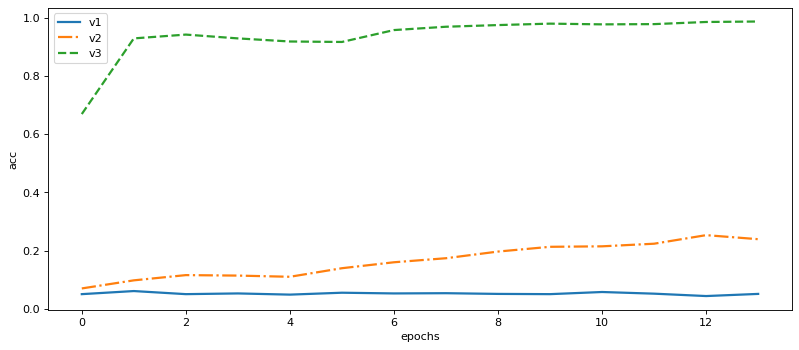

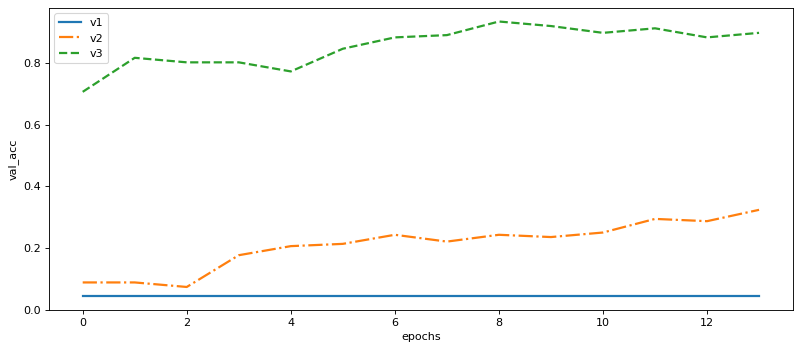

In [76]:
plt.figure(figsize=(12,5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_1.history['acc'][:14],'-',linewidth=2)
plt.plot(history_2.history['acc'][:14],'-.',linewidth=2)
plt.plot(history_3.history['acc'][:14],'--',linewidth=2)
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend(['v1','v2','v3'],loc='upper left')
plt.show()

plt.figure(figsize=(12,5), dpi=80, facecolor='w', edgecolor='k')

plt.plot(history_1.history['val_acc'][:14],'-',linewidth=2)
plt.plot(history_2.history['val_acc'][:14],'-.',linewidth=2)
plt.plot(history_3.history['val_acc'][:14],'--',linewidth=2)
plt.xlabel('epochs')
plt.ylabel('val_acc')
plt.legend(['v1','v2','v3'],loc='upper left')
plt.show()

## Conclusion
- 첫번째 model: 완전연결 레이어를 마지막에 연결, 좋지않는 성능
- 두번쨰 mdoel: 모델 앞부분의 특징을 바꾸는 것은 성능이 좋지 않게 나왔다.
- 세번째 model: 마지막 블록을 학습한 모델의 acc가 가장 좋게 나왔다(Transfer_learning의 장점)<br>

<p>-이렇게 미세조정한 모델들은 이제 꽃을 분류하는 모델로 미세조정 학습이 되었다.<br>
resnet모델은 1000개의 클래스를 분류하는 거대 imageset으로 학습하여 범용적인 성능을 갖고 있다.<br>
재학습을 통해 미세조정하면 현재 문제에는 적합하게 모델 학습되지만 범용적 성능은 조금씩 잃어버릴 것이다. <br> 즉 모든 경우에 완벽한 모델을 만드는 답은 존재하지 않는다.</p>